# Homework 2 - Fashion-MNIST (CNN)

## Define constants, functions and set random seed

In [1]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT  = 28
IMAGE_CHANNEL = 1
IMAGE_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)
LABEL_COUNT = 10
EXTEND_COPIES = 2
BATCH_SIZE = 256
EPOCHS = 320
SEED = 0xFFFF
RANDOM_VAL_SPLIT = False

import os
from os import path
from datetime import datetime
def create_result_dir() -> str:
    result_dir = "result." + datetime.today().strftime("%y%m%d-%H%M%S")
    if not path.exists(result_dir): os.makedirs(result_dir)
    else:
        result_dir_suffix = 0
        while path.exists(result_dir + "-" + str(result_dir_suffix)):
            result_dir_suffix += 1
        result_dir = result_dir + "-" + str(result_dir_suffix)
        os.makedirs(result_dir)
    return result_dir

import pandas, numpy
def prepare_data(data: pandas.DataFrame) -> numpy.ndarray:
    data = data.values.astype("float32") / 0xFF
    return data.reshape((data.shape[0], ) + IMAGE_SHAPE)

import scipy.ndimage
from keras.preprocessing import image
def extend_data(
    data_y: numpy.ndarray, data_x: numpy.ndarray, copies: int
) -> (numpy.ndarray, numpy.ndarray):
    datagen = image.ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True,
    )
    amount = data_y.shape[0]
    new_y = numpy.empty((amount * copies, data_y.shape[1]), dtype="float32")
    new_x = numpy.empty((amount * copies, ) + data_x.shape[1:], dtype="float32")
    for i in range(data_y.shape[0]):
        new_y[i * copies], new_x[i * copies] = data_y[i], data_x[i]
        j = 1
        for new_data in datagen.flow(
            x=data_x[i].reshape((1, ) + data_x.shape[1:]),
            batch_size=1,
            seed=SEED,
        ):
            if j >= copies: break
            new_y[i * copies + j] = data_y[i]
            new_x[i * copies + j] = new_data.reshape(data_x.shape[1:])
            j += 1
    return (new_y, new_x)

from matplotlib import pyplot
from keras import callbacks
def show_train_history(history: callbacks.History):
    fig, ax = pyplot.subplots(nrows=1, ncols=2)
    fig.set_size_inches(18, 6)
    ax[0].set_title("Model accuary")
    ax[0].plot(history.history["acc"])
    ax[0].plot(history.history["val_acc"])
    ax[0].set_ylabel("accuary")
    ax[0].set_xlabel("epoch")
    ax[0].legend(["result", "validation"], loc="upper left")
    ax[1].set_title("Model loss")
    ax[1].plot(history.history["loss"])
    ax[1].plot(history.history["val_loss"])
    ax[1].set_ylabel("loss")
    ax[1].set_xlabel("epoch")
    ax[1].legend(["result", "validation"], loc="upper left")
    pyplot.show()

import math
def show_data_image(data: numpy.ndarray, index: int, copies: int):
    fig, ax = pyplot.subplots(nrows=int(math.ceil(copies / 3)), ncols=3)
    fig.set_size_inches(18, int(math.ceil(copies / 3)) * 6)
    for i, each_ax in zip(range(0, copies), ax.flat):
        each_ax.matshow(
            data[index * copies + i].reshape(data.shape[1:3]),
            cmap=pyplot.cm.gray,
        )
    pyplot.show()

from numpy import random
random.seed(SEED)

Using plaidml.keras.backend backend.


## Read files and prepare data

In [2]:
import zipfile
from keras.utils import np_utils
# Github has 100MB limited of each file, so I zipped it.
# train = pandas.read_csv("data/train_data.csv")
train_zip = zipfile.ZipFile("data/train_data.zip")
train = pandas.read_csv(train_zip.open("train_data.csv"))
test = pandas.read_csv("data/test_data.csv")
train_labels, train_images = extend_data(
    np_utils.to_categorical(train["label"]),
    prepare_data(train.iloc[:, 1:]),
    copies=EXTEND_COPIES + 1,
)
test_images = prepare_data(test)

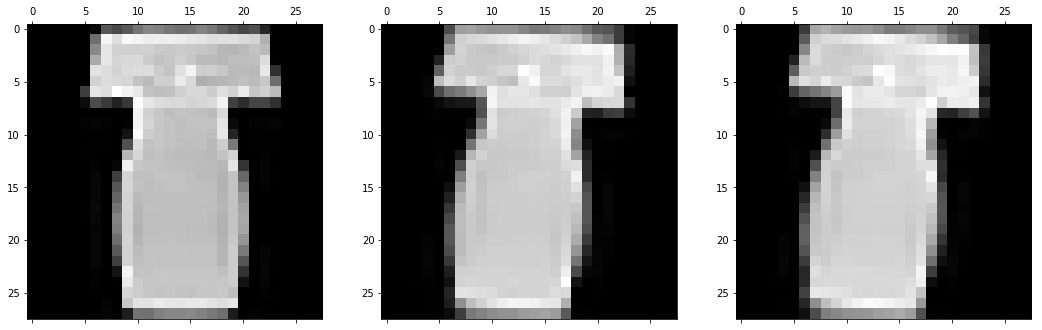

In [3]:
show_data_image(
    train_images,
    int(datetime.today().timestamp()) % (train_images.shape[0] // (EXTEND_COPIES + 1)),
    EXTEND_COPIES + 1,
)

## Create a model

In [4]:
# Scores in Kaggle Public Leaderboard
# 0.94266: Set RANDOM_VAL_SPLIT to False
#          Conv2D + MaxPooling2D / × 4 / Filters: 300, Kernel Size: 3
#          Dropout               / × 4 / Rate: 0.30, 0.36, 0.42, 0.48
# 0.94366: Set RANDOM_VAL_SPLIT to False
#          Conv2D + MaxPooling2D / × 4 / Filters:  96, Kernel Size: 4 
#          Dropout               / × 4 / Rate: 0.30, 0.36, 0.42, 0.48
# 0.94766: Set RANDOM_VAL_SPLIT to True
#          Conv2D + MaxPooling2D / × 4 / Filters: 240, Kernel Size: 3
#          Dropout               / × 4 / Rate: 0.28, 0.32, 0.36, 0.40
#          Dense                 / × 1 / Activation: ReLU, Units: 240

from keras import models, layers, initializers, activations, regularizers
model = models.Sequential([
    layers.Conv2D(
        filters=96,
        kernel_size=4,
        padding="same",
        activation=activations.relu,
        kernel_initializer=initializers.glorot_uniform(seed=SEED),
        input_shape=IMAGE_SHAPE,
    ),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),
    layers.Conv2D(
        filters=96,
        kernel_size=4,
        padding="same",
        activation=activations.relu,
        kernel_initializer=initializers.glorot_uniform(seed=SEED),
    ),
    layers.MaxPooling2D(),
    layers.Dropout(0.36),
    layers.Conv2D(
        filters=96,
        kernel_size=4,
        padding="same",
        activation=activations.relu,
        kernel_initializer=initializers.glorot_uniform(seed=SEED),
    ),
    layers.MaxPooling2D(),
    layers.Dropout(0.42),
    layers.Conv2D(
        filters=96,
        kernel_size=4,
        padding="same",
        activation=activations.relu,
        kernel_initializer=initializers.glorot_uniform(seed=SEED),
    ),
    layers.MaxPooling2D(),
    layers.Dropout(0.48),
    layers.Flatten(),
    ###
    # layers.Dense(
    #     units=240,
    #     activation=activations.relu,
    #     kernel_initializer=initializers.glorot_uniform(seed=SEED),
    # ),
    ###
    layers.BatchNormalization(),
    layers.Dense(
        LABEL_COUNT,
        activation=activations.softmax,
        kernel_initializer=initializers.glorot_normal(seed=SEED),
    ),
])

from keras import optimizers, losses
model.compile(
    optimizer=optimizers.Adam(amsgrad=True),
    loss=losses.categorical_crossentropy,
    metrics=["accuracy"],
)

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        1632      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 96)        147552    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 96)          147552    
__________

## Train the model

In [5]:
result_dir = create_result_dir()
model_filename = "model.{epoch:0%dd}-{val_loss:.4f}.hdf5" % len(str(abs(EPOCHS)))
model_path = path.join(result_dir, model_filename)

model_checkpoint = callbacks.ModelCheckpoint(
    model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
)
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=64,
    verbose=1,
)

if RANDOM_VAL_SPLIT:
    from sklearn import model_selection
    train_x, val_x, train_y, val_y = model_selection.train_test_split(
        train_images, train_labels,
        test_size=1 / 20,
        random_state=SEED,
    )
    val_data = (val_x, val_y)
else:
    train_x, train_y = train_images, train_labels
    val_data = None

history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[
        model_checkpoint,
        early_stopping,
    ],
    validation_split=1 / 20,
    validation_data=val_data,
)

Train on 171000 samples, validate on 9000 samples
Epoch 1/320
171000/171000 [==============================] - 65s 379us/step - loss: 0.6051 - acc: 0.7870 - val_loss: 0.3114 - val_acc: 0.8816

Epoch 00001: val_loss improved from inf to 0.31137, saving model to result.181202-152606\model.01-0.3114.hdf5
Epoch 2/320
171000/171000 [==============================] - 51s 301us/step - loss: 0.3617 - acc: 0.8705 - val_loss: 0.2692 - val_acc: 0.8966

Epoch 00002: val_loss improved from 0.31137 to 0.26922, saving model to result.181202-152606\model.02-0.2692.hdf5
Epoch 3/320
171000/171000 [==============================] - 51s 300us/step - loss: 0.3163 - acc: 0.8868 - val_loss: 0.2541 - val_acc: 0.9026

Epoch 00003: val_loss improved from 0.26922 to 0.25412, saving model to result.181202-152606\model.03-0.2541.hdf5
Epoch 4/320
171000/171000 [==============================] - 51s 300us/step - loss: 0.2933 - acc: 0.8942 - val_loss: 0.2324 - val_acc: 0.9120

Epoch 00004: val_loss improved from 0.25

Epoch 37/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1759 - acc: 0.9350 - val_loss: 0.1842 - val_acc: 0.9346

Epoch 00037: val_loss did not improve from 0.18316
Epoch 38/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1732 - acc: 0.9358 - val_loss: 0.1847 - val_acc: 0.9357

Epoch 00038: val_loss did not improve from 0.18316
Epoch 39/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1729 - acc: 0.9360 - val_loss: 0.1855 - val_acc: 0.9363

Epoch 00039: val_loss did not improve from 0.18316
Epoch 40/320
171000/171000 [==============================] - 51s 301us/step - loss: 0.1716 - acc: 0.9361 - val_loss: 0.1818 - val_acc: 0.9369

Epoch 00040: val_loss improved from 0.18316 to 0.18183, saving model to result.181202-152606\model.40-0.1818.hdf5
Epoch 41/320
171000/171000 [==============================] - 51s 299us/step - loss: 0.1706 - acc: 0.9374 - val_loss: 0.1850 - val_acc: 0.9347

Epoch 00041: 


Epoch 00077: val_loss did not improve from 0.16779
Epoch 78/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1460 - acc: 0.9459 - val_loss: 0.1757 - val_acc: 0.9371

Epoch 00078: val_loss did not improve from 0.16779
Epoch 79/320
171000/171000 [==============================] - 52s 304us/step - loss: 0.1461 - acc: 0.9455 - val_loss: 0.1696 - val_acc: 0.9419

Epoch 00079: val_loss did not improve from 0.16779
Epoch 80/320
171000/171000 [==============================] - 52s 301us/step - loss: 0.1449 - acc: 0.9456 - val_loss: 0.1709 - val_acc: 0.9408

Epoch 00080: val_loss did not improve from 0.16779
Epoch 81/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1458 - acc: 0.9455 - val_loss: 0.1730 - val_acc: 0.9422

Epoch 00081: val_loss did not improve from 0.16779
Epoch 82/320
171000/171000 [==============================] - 51s 301us/step - loss: 0.1448 - acc: 0.9455 - val_loss: 0.1726 - val_acc: 0.9414

Epoch 00082: val_loss di

171000/171000 [==============================] - 51s 298us/step - loss: 0.1232 - acc: 0.9544 - val_loss: 0.1777 - val_acc: 0.9400

Epoch 00161: val_loss did not improve from 0.16634
Epoch 162/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1227 - acc: 0.9545 - val_loss: 0.1711 - val_acc: 0.9412

Epoch 00162: val_loss did not improve from 0.16634
Epoch 163/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1241 - acc: 0.9535 - val_loss: 0.1713 - val_acc: 0.9432

Epoch 00163: val_loss did not improve from 0.16634
Epoch 164/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1247 - acc: 0.9538 - val_loss: 0.1795 - val_acc: 0.9402

Epoch 00164: val_loss did not improve from 0.16634
Epoch 165/320
171000/171000 [==============================] - 51s 298us/step - loss: 0.1238 - acc: 0.9538 - val_loss: 0.1738 - val_acc: 0.9420

Epoch 00165: val_loss did not improve from 0.16634
Epoch 166/320
171000/171000 [=====

#  Save history and predictions and show training result.

In [6]:
import pickle
with open(path.join(result_dir, "history.pickle"), "wb") as file:
    pickle.dump(history.history, file, pickle.HIGHEST_PROTOCOL)

import glob
model_files = sorted(glob.glob(path.join(result_dir, "model.*-*.hdf5")))
model = models.load_model(model_files[-1])
predictions = model.predict_classes(test_images)
pandas.DataFrame(
    data={
        "id": numpy.array(range(1, predictions.size + 1)),
        "label": predictions,
    },
).to_csv(
    path.join(result_dir, "predictions.csv"),
    index=False,
)

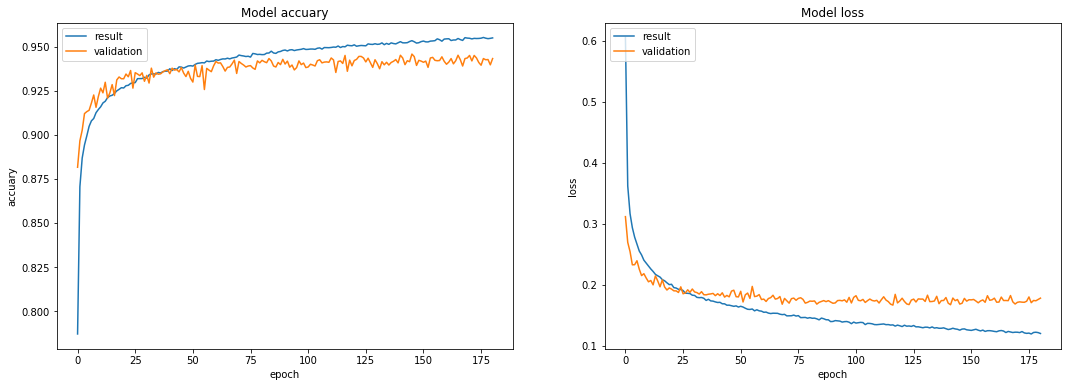

In [7]:
show_train_history(history)